## MLP
**Multi-Layer Perceptron** - каноничный вид искусственных нейронных сетей *прямого распространения*. Включает в себя один или более *скрытых полносвязных слоев*. В данном Jupyer-notebook представленная реализация MLP для решения задачи *многоклассовой классификации*.

#### Библиотеки
В первую очередь используется математическая библиотека NumPy, а также sklearn для загрузки датасетов и случайной перетасовки данных.

In [1]:
import numpy as np
from sklearn.utils import shuffle

In [2]:
import sklearn.datasets 
import sklearn.linear_model 
import matplotlib.pyplot as plt

In [3]:
#random seed, which's used in several funcs by default
seed = 42

#### Инициализация весов
Беря в расчет специфику функций активации и работу сети - веса должны быть случайно распределны в небольшой области нуля.
В данной реализации используется [*Xavier-подобная инициализация*](http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization)

In [4]:
def initialize_weights(mat_shape):
    np.random.seed(seed)    
    res = np.random.randn(*mat_shape)*np.sqrt(2 / (mat_shape[0] + mat_shape[1]))
    return res

In [5]:
print(initialize_weights((3,5)))

[[ 0.24835708 -0.06913215  0.32384427  0.76151493 -0.11707669]
 [-0.11706848  0.78960641  0.38371736 -0.23473719  0.27128002]
 [-0.23170885 -0.23286488  0.12098114 -0.95664012 -0.86245892]]


#### Деление на обучающую и валидационную выборки
Для проведения оценки работы сети, необходимо поделить генеральную выборку, предварительно перемешав примеры.

**_Важно:_** в данном коде используется нотация, в которой выборка подается на вход сети в формате **(m x n)**, где m - число примеров в выборке, n - число признаков.

In [6]:
def __train_test_split__(data, ratio, random_seed):
    #this func is auxiliary
    dset = shuffle(data, random_state = seed)
    return (dset[:int(len(dset) * ratio)], dset[int(len(dset) * ratio):])

In [7]:
def train_test_split(X, y, ratio = 0.8, random_seed = seed):
    #X, y - numpy array
    #input data should be in format m x n, where m is the number of samples for X,
    #n is the number of features and (m, ) for y
    assert len(X) == len(y), 'lengths of arrays are not the same'
    TrainX, TestX = __train_test_split__(X, ratio, random_seed)
    TrainY, TestY = __train_test_split__(y, ratio, random_seed)
    #converts 1D-array to 2D-array
    if len(TestY.shape) == 1:
        TestY = TestY[:,np.newaxis]
        TrainY = TrainY[:,np.newaxis]
    return (TrainX, TrainY, TestX, TestY)

In [8]:
print(train_test_split(np.array(range(15)).reshape((5,3)),np.array(range(5)).reshape((5,))))

(array([[ 3,  4,  5],
       [12, 13, 14],
       [ 6,  7,  8],
       [ 0,  1,  2]]), array([[1],
       [4],
       [2],
       [0]]), array([[ 9, 10, 11]]), array([[3]]))


#### Минибатчи
Данная реализация обучения сети поддерживает работу с минибатчами данных, что является обобщенным вариантом *Градиентного спуска* и *Стохастического градиентного спуска*. Для этих случаев сделайте размер mbatchsize равным *размеру выборки* и *1* - соответсвенно. Во время работы алгоритма данные *транспонируются*.

In [9]:
def minibatch_list(dataX, labelsY, mbatchsize = 32):
    #input data should be in format m x n, where m is the number of samples
    #and n is the number of features, y is m x 1
    #output data is in the format n x batchsize (transposed) in list
    assert dataX.shape[0] == labelsY.shape[0]
    
    data, labels = shuffle(dataX, labelsY)
    fulls = data.shape[0] // mbatchsize
    resX = []
    resY = []
    for i in range(fulls):
        resX.append(np.transpose(data[i * mbatchsize:(i+1) * mbatchsize]))
        resY.append(np.transpose(labels[i * mbatchsize:(i+1) * mbatchsize]))
    if data.shape[0] % mbatchsize != 0:
        resX.append(np.transpose(data[fulls*mbatchsize:]))
        resY.append(np.transpose(labels[fulls*mbatchsize:]))
    return (resX , resY)

In [10]:
x, y = minibatch_list(np.array(range(15)).reshape((5,3)), np.array(range(5)).reshape((5,1)), mbatchsize=2)
print(x, x[0].shape)
print(y, y[0].shape)

[array([[ 0,  9],
       [ 1, 10],
       [ 2, 11]]), array([[ 3, 12],
       [ 4, 13],
       [ 5, 14]]), array([[6],
       [7],
       [8]])] (3, 2)
[array([[0, 3]]), array([[1, 4]]), array([[2]])] (1, 2)


### Функции активации

#### Сигмоида
В [старых источниках](https://books.google.ru/books/about/%D0%9D%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D0%B5_%D1%81%D0%B5%D1%82%D0%B8_%D0%BF%D0%BE%D0%BB%D0%BD%D1%8B%D0%B9.html?hl=ru&id=LPMr0iA0muwC "Саймон Хайкин") можно найти так называемые *"сигмоидальные функции"*, к которым относятся такие популярные функции активации как *гиперболический тангенс* и *логистическая функция*(от которой подшло название *логистической регрессии*). Однако в более современных источниках все обозначают *"сигмоидой"* именно логистическую функцию. Её упрощённый вариант(без параметров) представлен ниже:

\begin{align}
\ \sigma(y) = \frac{1}{1 - e^{-y}} \\
\end{align}
где *y* - может быть и вектором и скаляром

In [11]:
def sigmoid(X):
    return 1 / (1 + np.exp(-X))

Также нам потребуется производная этой функции

In [12]:
def sigmoid_der(X):
    return sigmoid(X) * (1 - sigmoid(X))

In [13]:
print(sigmoid(np.array(range(15)).reshape((5,3))*0.1))
print(sigmoid_der(np.array(range(15)).reshape((5,3))*0.1))

[[ 0.5         0.52497919  0.549834  ]
 [ 0.57444252  0.59868766  0.62245933]
 [ 0.64565631  0.66818777  0.68997448]
 [ 0.7109495   0.73105858  0.75026011]
 [ 0.76852478  0.78583498  0.80218389]]
[[ 0.25        0.24937604  0.24751657]
 [ 0.24445831  0.24026075  0.23500371]
 [ 0.22878424  0.22171287  0.2139097 ]
 [ 0.20550031  0.19661193  0.18736988]
 [ 0.17789444  0.16829836  0.1586849 ]]


#### ReLU
Rectified Linear Unit - одна из наиболее пополярных функций активации

\begin{align}
\ ReLU(y) = \max(0,y) \\
\end{align}

In [14]:
def relu(X):
    return X * (X > 0.)

Также нам потребуется производная этой функции

In [15]:
def relu_der(X):
    return (X > 0.)*1.

In [16]:
print(relu(np.array(range(15)).reshape((5,3))*0.1))
print(relu_der(np.array(range(15)).reshape((5,3))*0.1))

[[ 0.   0.1  0.2]
 [ 0.3  0.4  0.5]
 [ 0.6  0.7  0.8]
 [ 0.9  1.   1.1]
 [ 1.2  1.3  1.4]]
[[ 0.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]]


### One-hot encoding
[Популярный способ закодировать](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/) некоторый набор классов в *sparse-vector*, где для каждой сущности выбирается индекс в массиве и ставится 1, если этот пример соотвествует этой сущности.

**_Важно:_** для бинарной классификации достаточно и обычного представления в виде серии 0 и 1, размерности m x 1, кроме случаев *классификации с отклонением*

In [17]:
def make_onehot(array, num_classes):
    #input array should be (m x 1) or (m, )
    if len(array.shape) > 1:
        array = array.reshape(len(array),)
    b = np.zeros((len(array), num_classes), dtype=np.int)
    b[np.arange(len(array)), array] = 1
    return b

In [18]:
print(make_onehot(np.array([1,0,3,2,1,0]).reshape(6,1), 4))

[[0 1 0 0]
 [1 0 0 0]
 [0 0 0 1]
 [0 0 1 0]
 [0 1 0 0]
 [1 0 0 0]]


In [19]:
print(make_onehot(np.array([1,0,3,2,1,0]).reshape(6,), 4))

[[0 1 0 0]
 [1 0 0 0]
 [0 0 0 1]
 [0 0 1 0]
 [0 1 0 0]
 [1 0 0 0]]


### Функция потерь
Для обучения сети, необходимо определить *функцию потерь*, которую мы будем оптимизировать.
В иностранный литературе встречается два похожих определения - *Loss function* и *Cost function*. Где Cost - сумма всех потерь за батч, разделенная на число примеров. В данной реализации вычисляется именно "Cost", но в соотвествии с общепринятой нотацией обозначается как "loss". В это же время производная этой функции вычисляется в векторном виде, т.е. сразу по *оценке y*. Также отметим, что *cross-entropy log loss, binary log loss, log loss* в случае с *бинарной* классификацией, означают одно и то же.

Для задачи *много-классовой классификации* вводится суммирование по *c* - числу классов. **_Важно:_** когда вы используете бинарную классификацию, убедитесь, что массив labels имеет размерность 1 x m, не ( , m)

\begin{align}
\ Binary~Cost(y, \hat{y}) = - \frac{1}{m} \sum_{i=1}^m y \cdot log( \hat{y}) + (1 - y) \cdot log(1- \hat{y})\\
\end{align}

\begin{align}
\ MultiClass~Cost(y, \hat{y}) = - \frac{1}{m} \sum_{i=1}^m \frac{1}{c} \sum_{j=1}^c y \cdot log( \hat{y}) + (1 - y) \cdot log(1- \hat{y})\\
\end{align}

In [20]:
def cross_entropy_log_loss(output, labels, epsilon = 1e-9):
    #output is c * m, so and labels is c * m
    #result is cross-entropy log-loss, 1 * 1
    assert output.shape == labels.shape, 'Shapes do not match'
    #to avoid log of 0
    eps = np.zeros(labels.shape) + epsilon
    y = np.maximum(eps, np.minimum(1 - eps, output))
    return -np.sum((labels * np.log(y) + (1 - labels) * np.log(1 - y))) / labels.shape[1] / labels.shape[0]

In [21]:
dummyL = make_onehot(np.array([1,0,3,2,1,0]).reshape(6,1), 4)
dummyY = (make_onehot(np.array([1,0,3,2,1,1]).reshape(6,1), 4))* 0.95
cross_entropy_log_loss(dummyY, dummyL)

0.99897769164325645

In [22]:
def cross_entropy_log_loss_der(output, labels, epsilon = 1e-9):
    assert output.shape == labels.shape, 'First dim is not 1'
    #to avoid log of 0
    eps = np.zeros(labels.shape) + epsilon
    y = np.maximum(eps, np.minimum(1 - eps, output))
    return - labels / y + (1 - labels) / (1 - y)

In [23]:
cross_entropy_log_loss_der(dummyY, dummyL)

array([[  1.00000000e+00,  -1.05263158e+00,   1.00000000e+00,
          1.00000000e+00],
       [ -1.05263158e+00,   1.00000000e+00,   1.00000000e+00,
          1.00000000e+00],
       [  1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
         -1.05263158e+00],
       [  1.00000000e+00,   1.00000000e+00,  -1.05263158e+00,
          1.00000000e+00],
       [  1.00000000e+00,  -1.05263158e+00,   1.00000000e+00,
          1.00000000e+00],
       [ -1.00000000e+09,   2.00000000e+01,   1.00000000e+00,
          1.00000000e+00]])

### Слой сети
В нашей сети можно будет задавать произвольное число своев произвольного размера. Для упрощения работы с кодом, инкапсулируем методы связанные с одним слоев в класс *"Layer"*.
При инициализации класса необходимо задать число нейронов на предыдущем слое и текущем, а также функцию активации (по умолчанию - сигмоида).

*Метод forward* производит прямой прогон слоя, т.е. активирует нейроны слоя. При этом вычисляются следующие значения и производятся следующие операции:

*m* - число примеров

*n* - число нейронов на предыдущем слое

*l* - число нейронов в этом слое

\begin{align}
\ Z_{l , m} = W_{l , n} \cdot X_{n , m} + b_{l, 1} \\
\ A_{l , m} = Activation( Z_{l , m} ) \\
\end{align}

*Метод backward* вычисляет (но не применяет) градиент данного слоя.

\begin{align}
\ dW = dZ \cdot X^{T} \\
\ dX = W^{T} \cdot dZ \\
\end{align}

In [24]:
class Layer:
    def __init__(self, input_size, output_size, activation='sigm'):
        self.W = initialize_weights((output_size, input_size))
        self.b = np.zeros((output_size, 1))
        self.Wgrad = np.zeros((output_size, input_size))
        self.bgrad = np.zeros((output_size, 1))
        self.Z = None
        self.X = None
        
        if activation == 'sigm':
            self.activation_func = sigmoid
            self.activation_func_der = sigmoid_der
        elif activation == 'relu':
            self.activation_func = relu
            self.activation_func_der = relu_der
        else:
            raise Exception('unknown func {}, try sigm or relu'.format(activation))
    
    def forward(self, data):
        #data should be in format n x m, where m - is num of examples, n - features
        assert data.shape[0] == self.W.shape[1], 'data dimension does not match'
        #this will be needed for gradient calc
        self.Z = np.dot(self.W, data) + self.b
        self.X = data
        return self.activation_func(self.Z)
    
    def backward(self, grad):
        assert grad.shape == self.Z.shape, 'gradient shape and Z do not match'
        Zgrad = self.activation_func_der(self.Z) * grad
        self.bgrad = np.sum(Zgrad, axis=-1, keepdims=True) #db = sum over axis=1
        self.Wgrad = np.dot(Zgrad, np.transpose(self.X)) #dW = dZ*X^T
        return np.dot(np.transpose(self.W),Zgrad) #dX = W^T*dZ

In [25]:
dummy = np.array(range(20)).reshape((2,10))*0.02
a = Layer(2,1,activation='sigm')
print(a.forward(dummy).shape)
dummygrad = np.array(range(10)).reshape((1,10))*0.02
print(a.backward(dummygrad).shape)
print(a.X)
print(a.Wgrad)
print(a.bgrad)

(1, 10)
(2, 10)
[[ 0.    0.02  0.04  0.06  0.08  0.1   0.12  0.14  0.16  0.18]
 [ 0.2   0.22  0.24  0.26  0.28  0.3   0.32  0.34  0.36  0.38]]
[[ 0.02849662  0.07349237]]
[[ 0.22497876]]


### Метрика качества
Существует много критериев оценки работы алгоритма, мы остановимся на "точности" - отношение числа верно указанных классов, ко всем примерам. Точность можно считать во время обучения, на валидационной выборке и на тестовой
\begin{align}
\ Accuracy = \frac{\sum^n _i [y _i=\hat{y}_i]}{n} \\
\end{align}

In [26]:
def accuracy_metrics(y, labels):
    assert len(y) == len(labels), 'length is not the same'
    summ = 0
    y = np.array(y)
    labels = np.array(labels)
    for i in range(len(y)):
        if np.array_equal(y[i],labels[i]):
            summ += 1
    return summ / len(y)

In [27]:
print(accuracy_metrics(make_onehot(np.array([1,0,3,2,1,0]).reshape(6,1), 4),
                       make_onehot(np.array([0,1,3,2,0,0]).reshape(6,1), 4)))

0.5


### Основной класс нейронной сети
При инициализации сети необходимо задать число нейронов в каждом слое, число которых соответствует мощности массива, и соответствующие функции активации. Слои хранятся в массиве *layers*

*Метод propagate forward* принимает на вход данные (n * m) и производит прямую прогонку сети, при этом каждый слой запоминает значения, вычисленные при прямом проходе, для дальнейшего вычисления градиента.

*Метод propagate backward* выполняет обратный проход по сети, находя по очереди все градиенты для каждого слоя. На вход метод принимает посчитанное значение производной функции потерь

*Метод update weights* изменяет веса нейронов слоев в соотвествии с оптимизирующим аглоритмом (Градиентный спуск)

*Метод predict* использует выход метода *propagate forward* для *оценки класса (0 или 1)*

*Метод fit* основной метод обучающий модель, последовательно выполняющий все операции, необходимые для обучения. Алгоритм имеет два критерия останова - по числу итераций и по размеру грудиента (если матричная норма получаемых градиентов меньше чем эпсилон, обучение прекращается). Эпоха - один прогон всей обучающей выборки, который в свою очередь включает один или несколько прогонов минибатчей. На каждой итерации вычислется выходное значение, потери, градент потерь, градиенты всех параметров. Затем градиенты применяются к параметрам.

In [28]:
import copy

In [30]:
class MLP:
    def __init__(self, input_size, layers, layers_activations):
        assert len(layers) == len(layers_activations), 'num of layers and activations does not match'
        self.layers = []
        self.layers.append(Layer(input_size=input_size, output_size=layers[0], activation=layers_activations[0]))
        for l in range(len(layers) - 1):
            self.layers.append(Layer(input_size=layers[l], output_size=layers[l + 1], activation=layers_activations[l + 1]))
    
    def propagate_forward(self, data):
        result = self.layers[0].forward(data)
        for l in range(len(self.layers) - 1):
            result = self.layers[l + 1].forward(result)
        return result
    
    def propagate_backward(self, gradient):
        grad = gradient
        for l in reversed(self.layers):
            grad = l.backward(grad)
    
    def update_weights(self, learning_rate, eps):
        is_updated = False
        for l in self.layers:
            if (np.linalg.norm(l.Wgrad) / (l.Wgrad.shape[0] * l.Wgrad.shape[1]) > eps):
                is_updated = True
            l.W = l.W - l.Wgrad * learning_rate
            l.b = l.b - l.bgrad * learning_rate
        return is_updated
    
    def predict(self, inputX):
        #support many data input types
        X = np.array(inputX)
        if len(X.shape) == 1:
            X = X.reshape(X.shape[0], 1)
        else:
            X = np.transpose(X)
        output = self.propagate_forward(X)
        #case of binary classification
        if output.shape[0] == 1:
            return np.squeeze(np.round(output).astype(np.int))
        return np.argmax(output, axis=0).astype(np.int)
    
    def fit(self, data, labels, validation=False, num_epochs = 100, eps = 0.01,
            learning_rate = 0.1, minibatch_size = 32, visualize=False, val_data=[], val_labels=[]):
        #input data should be in format m x n, where m is the number of samples
        #and n is the number of features
        if len(val_data) != 0:
            valdata = val_data
            vallabels = val_labels
        else:
            if validation:
                data, labels, valdata, vallabels = train_test_split(data, labels, ratio = 0.8)
        if visualize:
            plt.plot([],[])
            plt.ylim([0.,1.])
        losses = []
        vallosses = []
        minimal_loss = 1e10
        best_model = None
        proceed = True
        for i in range(num_epochs):
            if not proceed:
                break
            mbatchlistX, mbatchlistY = minibatch_list(data, labels, mbatchsize=minibatch_size)
            loss = 0.
            for mbatchnum in range(len(mbatchlistY)):
                prediction = self.propagate_forward(mbatchlistX[mbatchnum])
                loss = cross_entropy_log_loss(prediction, mbatchlistY[mbatchnum])
                loss_der = cross_entropy_log_loss_der(prediction, mbatchlistY[mbatchnum])
                self.propagate_backward(loss_der)
                proceed = self.update_weights(learning_rate=learning_rate, eps=eps)
            if visualize:
                if i % 500 == 0:
                    print('loss on iteration {} = {}'.format(i, np.round(loss, 5)))
                    accuracy_train = None
                    accuracy_val = None
                    if len(labels.shape) == 1:
                        #binary-classification case
                        accuracy_train = accuracy_metrics(self.predict(data), labels)
                        if validation:
                            accuracy_val = accuracy_metrics(self.predict(valdata), vallabels)
                    else:
                        accuracy_train = accuracy_metrics(make_onehot(self.predict(data), labels.shape[1]),labels)
                        if validation:
                            accuracy_val = accuracy_metrics(make_onehot(self.predict(valdata), labels.shape[1]),vallabels)
                    print('Accuracy on train: {}%'.format(round(accuracy_train*100, 2)))
                    if validation:
                        print('Accuracy on val: {}%'.format(round(accuracy_val*100, 2)))
                    print('-'*20) 
                losses.append(loss)
                if validation:
                    valpred = self.propagate_forward(np.transpose(valdata))
                    val_loss = cross_entropy_log_loss(valpred, np.transpose(vallabels))
                    vallosses.append(val_loss)
                    if val_loss < minimal_loss:
                        minimal_loss = val_loss
                        best_model = copy.deepcopy(self.layers)
        if visualize:
            train_loss, = plt.plot(losses, label="train")
            val_loss, = plt.plot(vallosses, label="val")
            plt.legend(handles=[train_loss, val_loss])
            plt.show()
        return best_model

### Данные
Для генерации обучающего множества воспользуемся уже упомянутым модулем библиотеки sklearn, а также разработанным модулем **data_gen**

In [31]:
import datagenv2 as dg

Метод *generate data* генерирует num_examples размеченных по num_classes классов точек в num_features-мерном пространстве в среднем удаленных друг от друга на dist_ratio радиусов

In [32]:
num_classes = 10

In [33]:
X, y = dg.generate_data(num_classes, 500, 2, True, 1.2)

#### Нормирование
Отнормируем данные. Это необходимо для более стабильной работы сети и не только. Например, логистическая регрессия вовсе не будет работать на немасштабированных данных. Для этого вычтем среднее по выборке и разделим на стандартное отклонение.
\begin{align}
\ Norm(X) = \frac{X - \mu (X)}{ \sigma (X)} \\
\end{align}

In [34]:
def normalize_data(X):
    return (X - np.mean(X)) / np.std(X)

Обратим ваше внимание, что в этой реализации сети, при *многоклассовой классификации* необходимо заранее *закодировать метки классов в one-hot encoding*. При этом размерность массива должна быть (m x c), где - m - число примеров, c - число классов. В случае *бинарной* классификации эта операция не требуется, можно подавать массив в виде (m, ) (или 1D-array)

In [35]:
X = normalize_data(X)
onehot = make_onehot(y, num_classes)

In [36]:
onehot.shape

(500, 10)

In [37]:
print(np.std(X), np.mean(X))
print(np.min(X), np.max(X))

1.0 -7.1054273576e-18
-2.01394543806 1.83811263531


In [38]:
#this cell contains nice dataset for binary classification 
#X, y = sklearn.datasets.make_moons(200, noise=0.20)

Разобьем наши данные уже оговоренной функцией train test split в отношении 80 на 20

In [39]:
TrainX, TrainY, TestX, TestY = train_test_split(X, onehot, random_seed=40)

In [40]:
TrainX.shape

(400, 2)

Пришло время задать архитектуру сети. Будем использовать трехслойную нейронную сеть (с одним скрытым слоем). Все активации нейронов - сигмоида.

In [41]:
a = MLP(2, [10, 5, num_classes], ['sigm','sigm','sigm'])

Осталось лишь запустить процесс обучения. При обучении можно выбрать отслеживание производительности на так-называемом validation set, т.е. на данных, не используемых в обучении сети. В конце обучения будет построен график функции потерь в зависимости от итерации

In [42]:
print(len(TrainX))

400


loss on iteration 0 = 0.64299
Accuracy on train: 10.94%
Accuracy on val: 10.0%
--------------------
loss on iteration 500 = 0.02382
Accuracy on train: 99.69%
Accuracy on val: 98.75%
--------------------
loss on iteration 1000 = 0.00736
Accuracy on train: 100.0%
Accuracy on val: 100.0%
--------------------
loss on iteration 1500 = 0.00415
Accuracy on train: 100.0%
Accuracy on val: 100.0%
--------------------


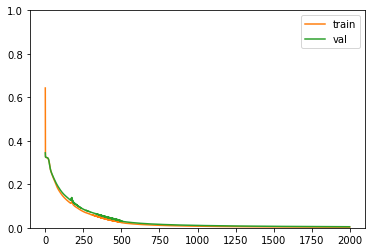

In [43]:
a.fit(TrainX, TrainY, validation=True, num_epochs=2000, minibatch_size = int(len(TrainX) * 0.8),
      learning_rate=0.01, eps=0.001, visualize=True)

In [122]:
X, y = sklearn.datasets.load_iris(return_X_y=True)
X = normalize_data(X)
onehot = make_onehot(y, 3)
TrainX, TrainY, TestX, TestY = train_test_split(X, onehot, random_seed=1, ratio=0.6)

loss on iteration 0 = 0.71065
Accuracy on train: 38.89%
Accuracy on val: 25.0%
--------------------
loss on iteration 500 = 0.03013
Accuracy on train: 97.78%
Accuracy on val: 96.67%
--------------------
loss on iteration 1000 = 0.02294
Accuracy on train: 97.78%
Accuracy on val: 96.67%
--------------------
loss on iteration 1500 = 0.0168
Accuracy on train: 98.89%
Accuracy on val: 96.67%
--------------------
loss on iteration 2000 = 0.00427
Accuracy on train: 100.0%
Accuracy on val: 96.67%
--------------------
loss on iteration 2500 = 0.00274
Accuracy on train: 100.0%
Accuracy on val: 96.67%
--------------------
loss on iteration 3000 = 0.00198
Accuracy on train: 100.0%
Accuracy on val: 96.67%
--------------------
loss on iteration 3500 = 0.00153
Accuracy on train: 100.0%
Accuracy on val: 96.67%
--------------------
loss on iteration 4000 = 0.00122
Accuracy on train: 100.0%
Accuracy on val: 96.67%
--------------------
loss on iteration 4500 = 0.00101
Accuracy on train: 100.0%
Accuracy on

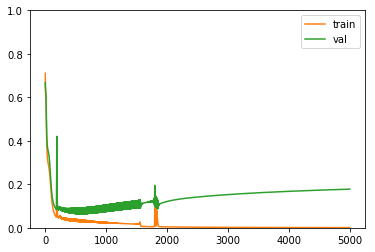

In [123]:
a = MLP(4, [10, 5, 3], ['sigm', 'sigm', 'sigm'])
best_layers = a.fit(TrainX, TrainY, validation=True, num_epochs=5000, minibatch_size = len(TrainX),
      learning_rate=0.0171, eps=0.001, visualize=True, val_data = TestX, val_labels = TestY)
best_model = MLP(4, [10, 5, 3], ['sigm','sigm', 'sigm'])
best_model.layers = best_layers

In [124]:
pred = best_model.predict(TrainX)
pred = make_onehot(pred, 3)
print('Точность классификации на общей обучающей выборке - {}% !'.format(round(accuracy_metrics(pred, TrainY)*100,2)))

Точность классификации на общей обучающей выборке - 98.89% !


In [125]:
pred = best_model.predict(TestX)
pred = make_onehot(pred, 3)
print('Точность классификации на тестовой выборке - {}% !'.format(round(accuracy_metrics(pred, TestY)*100,2)))

Точность классификации на тестовой выборке - 96.67% !


### Оптимизация гипер-параметров сети

In [ ]:
grid_dict =[
{
    'parameter': 'learning_rate',
    'start': 0.001,
    'end': 1.,
    'points': 5,
    'log': False,
    'int': False
},{
    'parameter': 'minibatch_size',
    'start': 1,
    'end': 256,
    'points': 5,
    'log': False,
    'int': True
},
#     {
#     'parameter': 'eps',
#     'start': 0.001,
#     'end': 0.01,
#     'points': 2,
#     'log': False,
#     'int': False
# },
]

In [ ]:
grid_dict

In [ ]:
from itertools import product
from copy import deepcopy
def grid_search(model, dictionary, data, labels):
    data, labels, val_data, val_labels = train_test_split(data, labels, ratio = 0.8)
    num_parameters = len(dictionary)
    minimal_loss = 10e9
    minimal_dict = {}
    linspaces = []
    #we'll be saving to this dict best values
    for dic in dictionary:
        minimal_dict[dic['parameter']] = None
        linspaces.append(np.linspace(dic['start'], dic['end'], dic['points']))
    iterator = product(*linspaces)
    for i in iterator:
        model_copy = deepcopy(model)
        feed_dict = {}
        for j in range(num_parameters):
            if dictionary[j]['int']:
                feed_dict[dictionary[j]['parameter']] = int(i[j])
            else:
                feed_dict[dictionary[j]['parameter']] = i[j]
        model_copy.fit(data, labels, num_epochs=50, **feed_dict)
        val_pred = model_copy.propagate_forward(np.transpose(val_data))
        val_loss = cross_entropy_log_loss(val_pred, np.transpose(val_labels))
        if val_loss < minimal_loss:
            minimal_loss = val_loss
            minimal_dict = feed_dict
    return (minimal_loss, minimal_dict)

In [ ]:
a = MLP(2, [10, 5, num_classes], ['sigm','sigm','sigm'])

In [ ]:
mloss, mdict = grid_search(a, grid_dict, TrainX, TrainY)

In [ ]:
print(mloss, mdict)

In [ ]:
a.fit(TrainX, TrainY, num_epochs=10000, eps=0.001, validation=True, visualize=True, **mdict)

Последний этап оценки качества сети - это ее показатель на тестовой выборке.

In [ ]:
pred = a.predict(TestX)

In [ ]:
pred = make_onehot(pred, num_classes)

In [ ]:
print('Точность классификации на тестовой выборке - {}% !'.format(round(accuracy_metrics(pred, TestY)*100,2)))

Вы могли заметить, что как второй критерий останова, испольузется порог нормы градиента весов. Посмотрим, чем они равны для каждого слоя после последней эпохи обучения

In [ ]:
for l in a.layers:
    print(np.linalg.norm(l.Wgrad) / (l.Wgrad.shape[0] * l.Wgrad.shape[1]))

Вспомогательная функция для постреония decision-boundary графика

In [108]:
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

Посмотрим на "сырые" данные

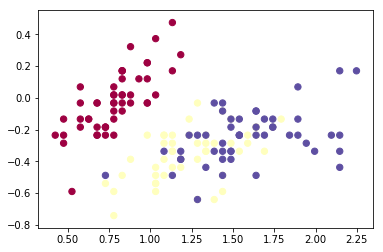

In [109]:
# Generate a dataset and plot it
np.random.seed(0)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)
plt.show()

Для сравнения посмотрим как с задачей справилась логистическая регрессия

In [ ]:
# Train the logistic regression classifier
clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(X, y)
# Plot the decision boundary (the method is in the main code link provided in the end)
plot_decision_boundary(lambda x: clf.predict(x))
plt.title("Logistic Regression")
plt.show()

И наконец, наш перцептрон

In [110]:
plot_decision_boundary(lambda x: a.predict(x))
plt.title("MLP")
plt.show()

AssertionError: data dimension does not match